<a href="https://colab.research.google.com/github/AlphaKermit-999/AI-Topics-learnings/blob/main/Advanced_AI/Copy_of_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import UpSampling2D

In [2]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
EPOCHS = 25
NOISE_DIM = 100
NUM_EXAMPLES_TO_GENERATE = 16

In [3]:
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train.shape

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


(60000, 28, 28)

In [4]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_train.shape

(60000, 28, 28, 1)

In [5]:
x_train = (x_train - 127.5) / 127.5 # all values are compressed into [-1,1]

In [6]:
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [9]:
7*7*256 # -> Number of Neurons

12544

In [10]:
def make_generator_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(NOISE_DIM,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Reshape((7, 7, 256)),
        tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    return model

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
generator = make_generator_model()
discriminator = make_discriminator_model()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = checkpoint_dir + "/ckpt"
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [18]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [19]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
        print("_____ EPOCH :", epoch, "_____")
        generate_and_save_images(generator, epoch + 1, seed)

        if (epoch + 1) % 5 == 0:  # At every 5th epoch we are trying to save the checkpoint
            checkpoint.save(file_prefix=checkpoint_prefix)

    generate_and_save_images(generator, epochs, seed)

In [20]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i, :, :, 0] + 1) / 2.0, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:789: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


_____ EPOCH : 0 _____


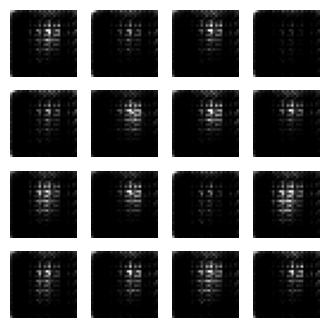

_____ EPOCH : 1 _____


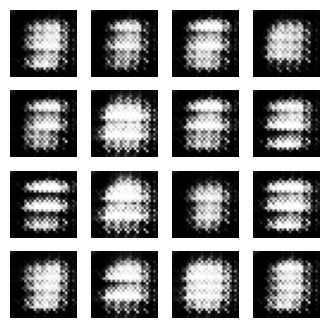

_____ EPOCH : 2 _____


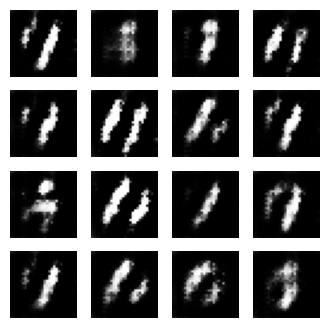

_____ EPOCH : 3 _____


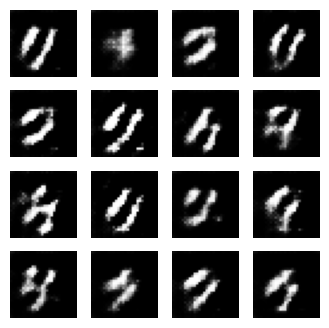

_____ EPOCH : 4 _____


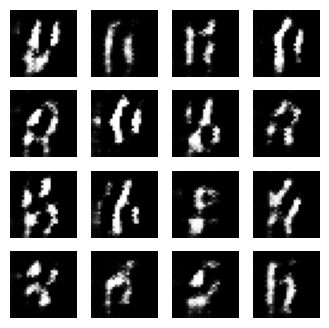

_____ EPOCH : 5 _____


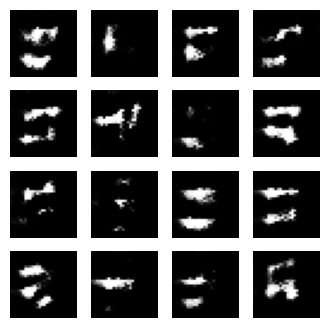

_____ EPOCH : 6 _____


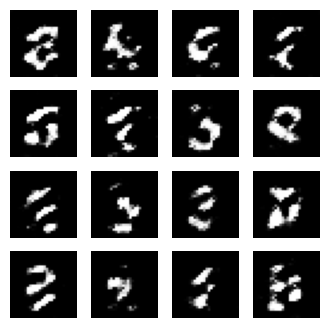

_____ EPOCH : 7 _____


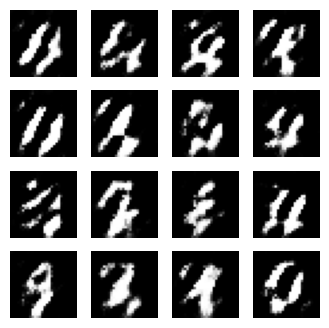

_____ EPOCH : 8 _____


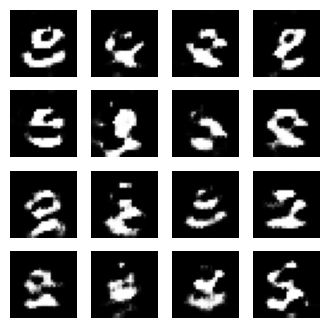

_____ EPOCH : 9 _____


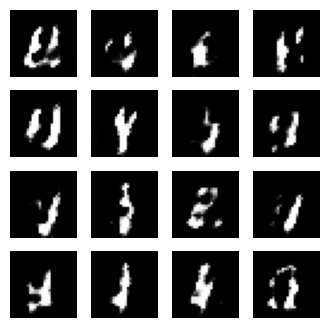

_____ EPOCH : 10 _____


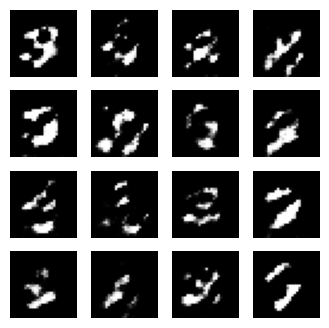

_____ EPOCH : 11 _____


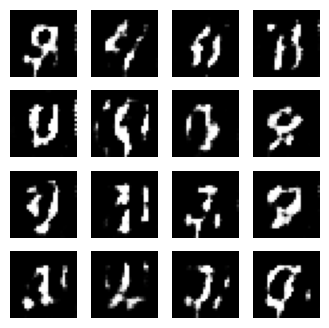

_____ EPOCH : 12 _____


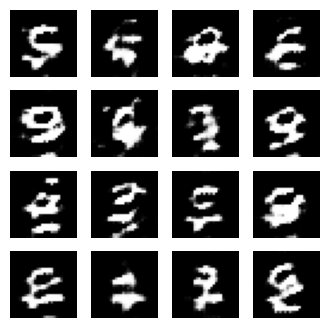

_____ EPOCH : 13 _____


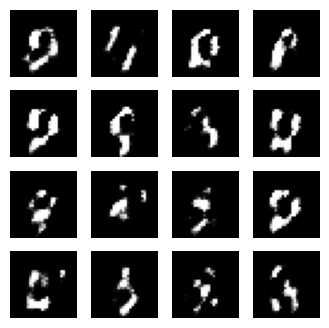

_____ EPOCH : 14 _____


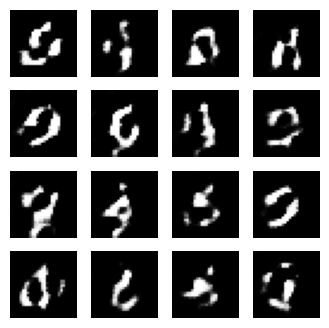

_____ EPOCH : 15 _____


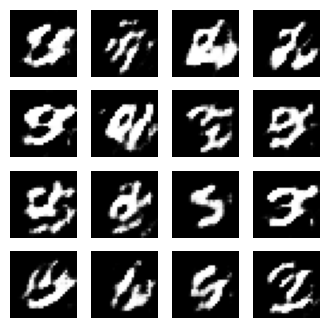

_____ EPOCH : 16 _____


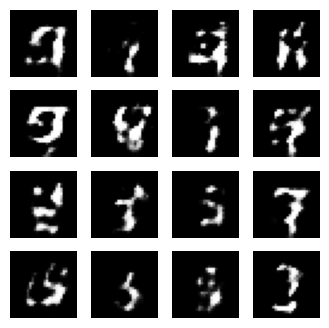

_____ EPOCH : 17 _____


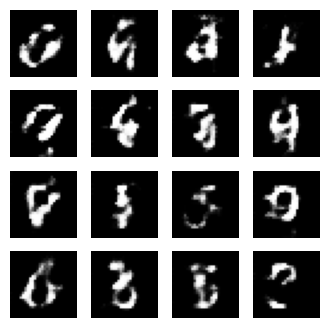

_____ EPOCH : 18 _____


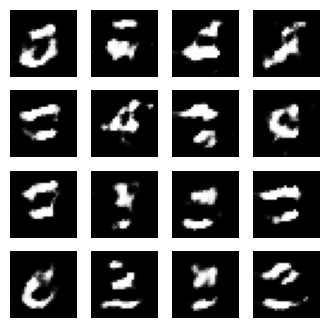

_____ EPOCH : 19 _____


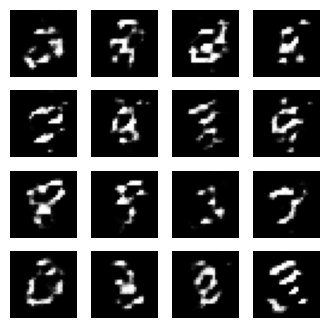

_____ EPOCH : 20 _____


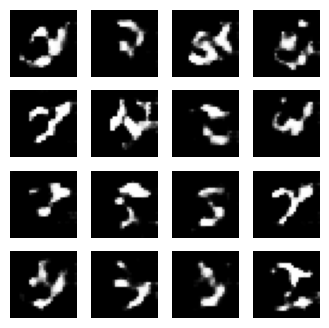

_____ EPOCH : 21 _____


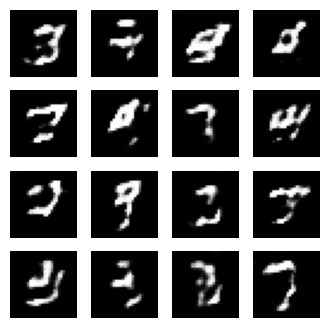

_____ EPOCH : 22 _____


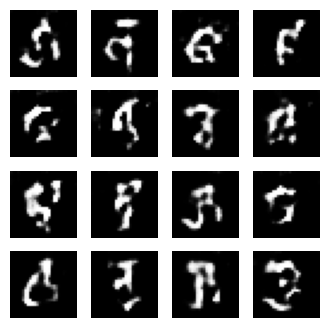

_____ EPOCH : 23 _____


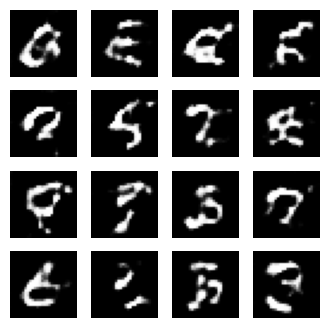

_____ EPOCH : 24 _____


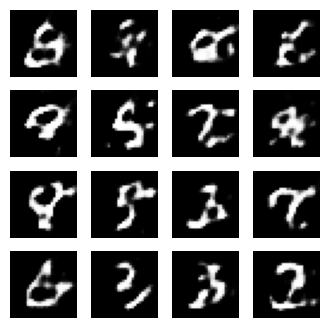

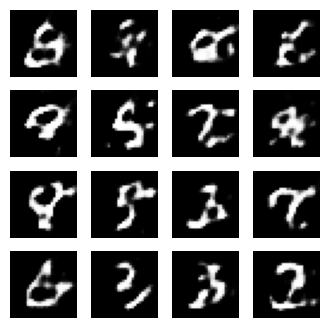

In [21]:
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])

train(dataset, EPOCHS)
